In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.python.platform.build_info import build_info
from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model #type:ignore

from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore
from tensorflow.keras.losses import CategoricalFocalCrossentropy #type:ignore
from sklearn.utils.class_weight import compute_class_weight

from pathlib import Path
import os
import shutil
import random

In [2]:
params = {
    'filters': 64,
    'conv_layers': 3,
    'dense_units': 128,
    'dropout': 0.30,
    'batch_norm': True,
    'optimizer': "adam",
    'lr': 1e-3,
    'flattening_layers': "GAP2D",
    'random_state': 42
}

In [3]:
current_dir = Path(os.getcwd())

data_dir = current_dir.parent / "data"

train_dir = data_dir / "train"
val_dir = data_dir / "valid"
test_dir = data_dir / "test"

model_name = "Sequential_Model"
checkpoints_dir = current_dir.parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

checkpoint_file_name = model_name + "-3cl.h5"

print(f"{'Project Root:':<25}{current_dir.parent}")
print(f"{'Train Directory:':<25}{train_dir}")
print(f"{'Validation Directory:':<25}{val_dir}")
print(f"{'Test Directory:':<25}{test_dir}")
print(f"{'Checkpoints Directory:':<25}{checkpoints_dir}")
print(f"{'Checkpoint File Name:':<25}{checkpoint_file_name}")

Project Root:            c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier
Train Directory:         c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\train
Validation Directory:    c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\valid
Test Directory:          c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\test
Checkpoints Directory:   c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\Sequential_Model
Checkpoint File Name:    Sequential_Model-3cl.h5


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.


In [5]:
class_labels = train_generator.classes
class_weight_dict = dict(
    enumerate(
        compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    )
)
class_weight_dict

{0: np.float64(4.883333333333334),
 1: np.float64(0.9301587301587302),
 2: np.float64(0.9242902208201893),
 3: np.float64(0.9301587301587302),
 4: np.float64(0.9099378881987578),
 5: np.float64(0.846820809248555),
 6: np.float64(0.9361022364217252),
 7: np.float64(0.8772455089820359),
 8: np.float64(0.9301587301587302)}

In [ ]:
modelcheckpoint = ModelCheckpoint(str(checkpoints_dir / checkpoint_file_name), monitor="val_loss", save_best_only=True, verbose=0)

callbacks = [
    modelcheckpoint,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.33, patience=2, min_lr=1e-6)
]

model = Sequential()
filters = params['filters']
for i in range(params['conv_layers']):
    if i == 0:
        model.add(Conv2D(filters, (3,3), activation='relu',kernel_regularizer=l2(0.001) ,input_shape=(64, 64, 3)))
    else:
        model.add(Conv2D(filters, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    if params['batch_norm']:
        model.add(BatchNormalization())
    filters *= 2  # Double filters each block
    
if params["flattening_layers"] == "GAP2D":
    model.add(GlobalAveragePooling2D())
    model.add(Dense(params['dense_units'], activation='relu', kernel_regularizer=l2(0.001)))
else:
    model.add(Flatten())
    model.add(Dense(params['dense_units'], activation='relu'))
    
model.add(Dropout(params['dropout']))
model.add(Dense(train_generator.num_classes, activation='softmax'))

if params['optimizer'] == 'adam':
    opt = Adam(learning_rate=params['lr'])
elif params['optimizer'] == 'rmsprop':
    opt = RMSprop(learning_rate=params['lr'])
else:
    opt = SGD(learning_rate=params['lr'], momentum=0.9)
    

model.compile(
    optimizer=opt, 
    loss=CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,218,205 (4.65 MB)

 Trainable params: 405,769 (1.55 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 811,540 (3.10 MB)

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.3302 - loss: 0.4660

83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 633ms/step - accuracy: 0.3265 - loss: 0.4608 - val_accuracy: 0.1171 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 601ms/step - accuracy: 0.3549 - loss: 0.4228 - val_accuracy: 0.1211 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 700ms/step - accuracy: 0.4099 - loss: 0.3817 - val_accuracy: 0.1079 - val_loss: 0.8146 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.4869 - loss: 0.3284 - val_accuracy: 0.1671 - val_loss: 0.8193 - learning_rate: 3.3000e-04
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5468 - loss: 0.2985 - val_accuracy: 0.1961 - val_loss: 0.6953 - learning_rate: 3.3000e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5691 - loss: 0.2821

83/83 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5817 - loss: 0.2804 - val_accuracy: 0.2461 - val_loss: 0.5389 - learning_rate: 1.0890e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5858 - loss: 0.2729

83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5882 - loss: 0.2724 - val_accuracy: 0.3289 - val_loss: 0.4428 - learning_rate: 1.0890e-04
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6139 - loss: 0.2599

83/83 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5973 - loss: 0.2667 - val_accuracy: 0.4447 - val_loss: 0.3804 - learning_rate: 1.0890e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6255 - loss: 0.2534

83/83 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6128 - loss: 0.2576 - val_accuracy: 0.4500 - val_loss: 0.3715 - learning_rate: 1.0890e-04
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.6271 - loss: 0.2522

83/83 ━━━━━━━━━━━━━━━━━━━━ 72s 870ms/step - accuracy: 0.6341 - loss: 0.2519 - val_accuracy: 0.5303 - val_loss: 0.3031 - learning_rate: 1.0890e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6443 - loss: 0.2503

83/83 ━━━━━━━━━━━━━━━━━━━━ 65s 781ms/step - accuracy: 0.6352 - loss: 0.2489 - val_accuracy: 0.5566 - val_loss: 0.2961 - learning_rate: 1.0890e-04
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 712ms/step - accuracy: 0.6378 - loss: 0.2435 - val_accuracy: 0.4658 - val_loss: 0.3430 - learning_rate: 1.0890e-04
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6849 - loss: 0.2302

83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 669ms/step - accuracy: 0.6663 - loss: 0.2319 - val_accuracy: 0.5882 - val_loss: 0.2784 - learning_rate: 1.0890e-04
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 685ms/step - accuracy: 0.6727 - loss: 0.2285 - val_accuracy: 0.4895 - val_loss: 0.3227 - learning_rate: 1.0890e-04
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 669ms/step - accuracy: 0.6955 - loss: 0.2202 - val_accuracy: 0.5000 - val_loss: 0.3214 - learning_rate: 1.0890e-04
Epoch 16/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7122 - loss: 0.2131

83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 675ms/step - accuracy: 0.7027 - loss: 0.2144 - val_accuracy: 0.6237 - val_loss: 0.2504 - learning_rate: 3.5937e-05
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 677ms/step - accuracy: 0.7000 - loss: 0.2103 - val_accuracy: 0.5724 - val_loss: 0.2718 - learning_rate: 3.5937e-05
Epoch 18/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 667ms/step - accuracy: 0.7205 - loss: 0.2065 - val_accuracy: 0.6118 - val_loss: 0.2647 - learning_rate: 3.5937e-05
Epoch 19/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 663ms/step - accuracy: 0.7235 - loss: 0.2034 - val_accuracy: 0.6092 - val_loss: 0.2596 - learning_rate: 1.1859e-05
Epoch 20/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7095 - loss: 0.2039

83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 708ms/step - accuracy: 0.7088 - loss: 0.2048 - val_accuracy: 0.6289 - val_loss: 0.2485 - learning_rate: 1.1859e-05
Epoch 21/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 693ms/step - accuracy: 0.7220 - loss: 0.2036 - val_accuracy: 0.6421 - val_loss: 0.2496 - learning_rate: 1.1859e-05
Epoch 22/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 669ms/step - accuracy: 0.7353 - loss: 0.1997 - val_accuracy: 0.6276 - val_loss: 0.2534 - learning_rate: 1.1859e-05
Epoch 23/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 704ms/step - accuracy: 0.7209 - loss: 0.2031 - val_accuracy: 0.6211 - val_loss: 0.2560 - learning_rate: 3.9135e-06
Epoch 24/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 703ms/step - accuracy: 0.7179 - loss: 0.2008 - val_accuracy: 0.6250 - val_loss: 0.2550 - learning_rate: 3.9135e-06
Epoch 25/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 703ms/step - accuracy: 0.7285 - loss: 0.1987 - val_accuracy: 0.6224 - val_loss: 0.2556 - learning_rate: 1.2915e-06
Epoch 26/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 721ms/step - accuracy

In [10]:
def evaluate_model(model, test_ds, class_names):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest Results:\nAccuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

    preds = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(preds, axis=1)

    if hasattr(test_ds, 'labels'):
        y_true = test_ds.labels
    else:
        y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    print('\nClassification Report:\n')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return test_acc, test_loss, y_pred


Test Results:
Accuracy: 0.6448 | Loss: 0.2455
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step


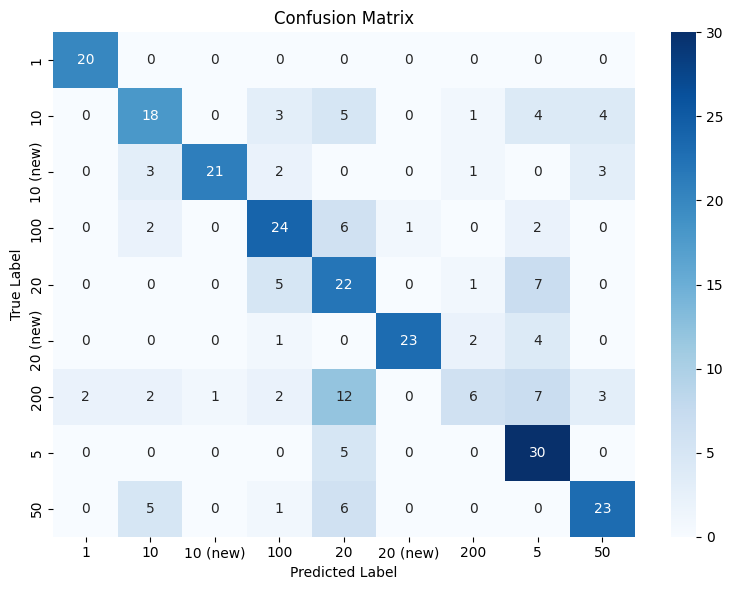


Classification Report:

              precision    recall  f1-score   support

           1     0.9091    1.0000    0.9524        20
          10     0.6000    0.5143    0.5538        35
    10 (new)     0.9545    0.7000    0.8077        30
         100     0.6316    0.6857    0.6575        35
          20     0.3929    0.6286    0.4835        35
    20 (new)     0.9583    0.7667    0.8519        30
         200     0.5455    0.1714    0.2609        35
           5     0.5556    0.8571    0.6742        35
          50     0.6970    0.6571    0.6765        35

    accuracy                         0.6448       290
   macro avg     0.6938    0.6646    0.6576       290
weighted avg     0.6736    0.6448    0.6364       290



In [11]:
test_acc, test_loss, y_pred = evaluate_model(model, test_generator, list(test_generator.class_indices.keys()))

In [12]:
def plot_training_curves(history, test_acc=0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

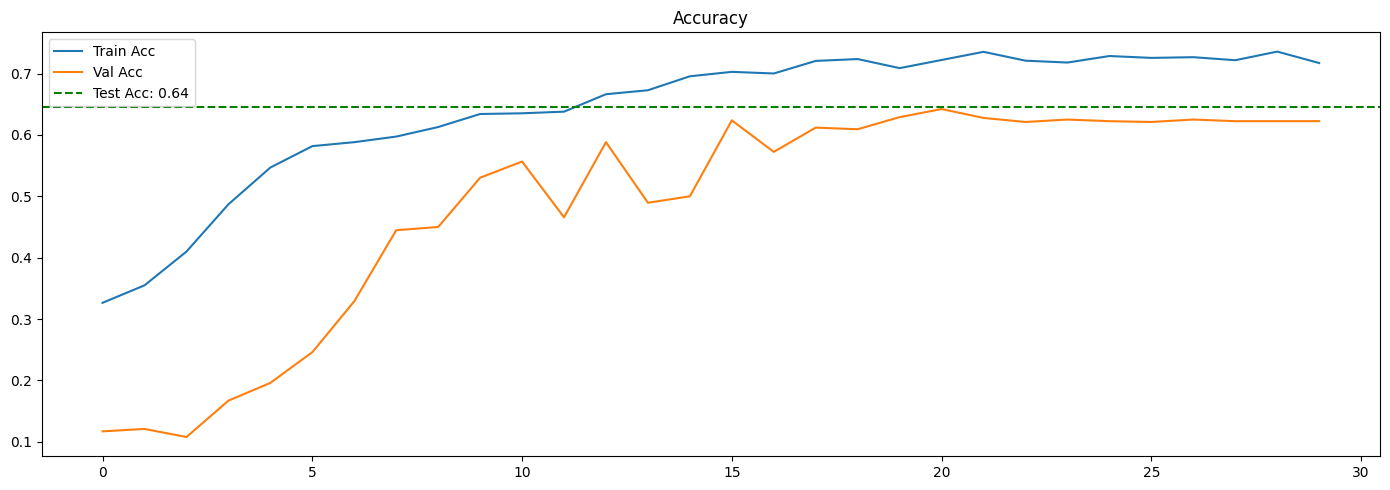

In [13]:
plot_training_curves(history, test_acc=test_acc)